train sizes: X, y
(36564, 25) (36564,)
test sizes: X, y
(9141, 25) (9141,)
Coefficients:
[ 3.08885981e-03 -4.34942715e-04  3.16278078e+00  5.22719377e+01
  9.08233358e-02 -5.23070299e+02 -3.11828412e-02  7.38577478e+03
 -5.23500886e+02  2.83810412e+00  1.46824760e-06  3.96055641e-03
  9.22320147e+01  2.24761561e+01 -2.34012518e+02 -1.89489056e-02
 -8.91919092e+00 -9.90125864e-01 -3.46483969e+01  1.22819601e+01
 -2.31112118e+01 -4.55275495e+00 -4.97973415e+01  1.66879831e+01
  4.66696397e+02]
Intercept:
-1247.8917678677522
Y predicted size
R2 Score:
0.7531699465897895
Mean squared error (MSE) 5526024.475749682
       Actual value  Predicted value   Difference
11240        1303.0      1100.018065   202.981935
34961        4248.0      2927.184959  1320.815041
31403          69.0       105.163201   -36.163201
10960          17.0      -166.619856   183.619856
13021         932.0       887.785105    44.214895
11621           6.0       558.688954  -552.688954
39983          16.0       -11.243

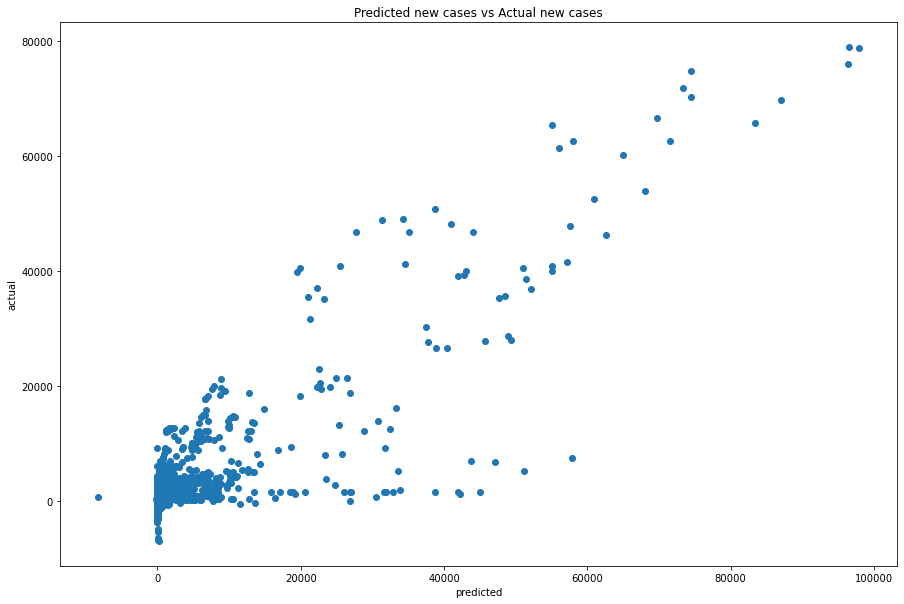

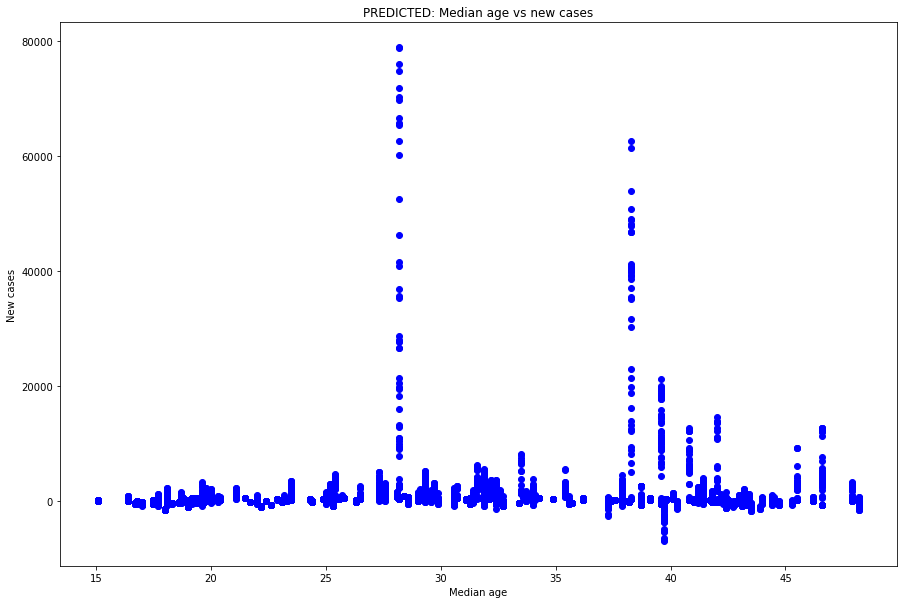

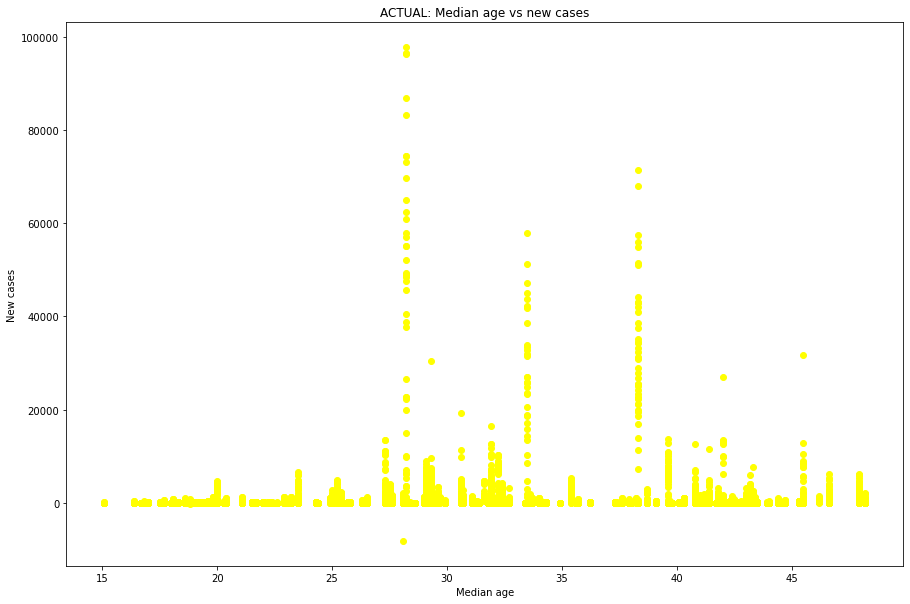

In [77]:
import pandas as pd
import missingno as msno
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def toBool(any):
    return 1.00 if bool(any) else 0.00


# Read csv and convert test features to bool
df = pd.read_csv('./covid.csv', low_memory=False, converters={'tests_units': toBool})
# Display all columns setting 
pd.set_option('display.max_columns', None)


labels = ['total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths','new_deaths', 'new_deaths_smoothed', 
                    'total_cases_per_million', 'new_cases_per_million','new_cases_smoothed_per_million', 
                    'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million']

################# FIX INCOMPLETENESS OF DATASET #####################

# Removes international and world rows
df = df.drop(df[pd.isna(df.continent)].index)
# Removes rows where labels are NaN
for label in labels:
    df = df.drop(df[pd.isna(df[label])].index)
    

# Transforms test features to 0 if there was not tested (if test_units = 0 then there was not tested yet)
df.loc[df['tests_units'] == 0.00, 
       ['new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_per_case', 'positive_rate']] \
        = 0, 0, 0, 0, 0, 0, 0, 0


# Transforms NaN values to the mean value of that feature
numeric_columns = df.select_dtypes(include='number').columns
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
df[numeric_columns] = pd.DataFrame(imputer.fit_transform(df[numeric_columns]))


# Removes rows where only Iso code etc. are filled
df.dropna(inplace=True)

# ---------------------- TODO: DETECT AND REMOVE OUTLIERS TO IMPROVE PERFORMANCE ------------------------------
## https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba



# Creates labels and features
non_numeric_features = df.select_dtypes(exclude='number').columns
features = df.drop(non_numeric_features, axis=1)
features = features.drop(labels, axis=1)



#################### Define what to predict(y) and what to predict by(X) #############
X = features
y = df['new_cases']



#################### Split data between learning and test data ################
# ---------------------- TODO: (not sure if needed for current y because R2 score is high, maybe for other Y) REMOVE BIAS FROM TRAIN AND TEST SPLITS ?  -> SOLVE BY USING K-FOLD ? ------------------------------
x_train,x_test,y_train,y_test = train_test_split(X, y,test_size=0.2, random_state=0)

print('train sizes: X, y')
print(x_train.shape, y_train.shape)
print('test sizes: X, y')
print(x_test.shape, y_test.shape)



###################### TRAINING MODEL ####################

# Train a model
ml = LinearRegression()
ml.fit(x_train, y_train)

# Check coefficients
print('Coefficients:')
print(ml.coef_)

# Check intercept
print('Intercept:')
print(ml.intercept_)


###################### MODEL PERFORMANCE #################

# Predict y
y_predicted = ml.predict(x_test)
print('Y predicted size')

# Validate predicted y
print('R2 Score:')
print(r2_score(y_test, y_predicted))
print('Mean squared error (MSE)', mean_squared_error(y_test, y_predicted))

# Display differences in numbers
pred_y_df = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_predicted, 'Difference': y_test - y_predicted})
print(pred_y_df[0:20])

# Visualize the validation results
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_predicted)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Predicted new cases vs Actual new cases')
plt.show()




############### INSIGHTS #####################

#----------------- TODO: Visualize more insights -> causes for cases and deaths -------------------


# Visualize Insight 1:
plt.figure(figsize=(15, 10))
plt.xlabel('Median age')
plt.ylabel('New cases')
plt.title('PREDICTED: Median age vs new cases')
plt.scatter(x_test['median_age'], y_predicted, color='blue')
plt.show()

plt.figure(figsize=(15, 10))
plt.xlabel('Median age')
plt.ylabel('New cases')
plt.title('ACTUAL: Median age vs new cases')
plt.scatter(x_test['median_age'], y_test, color='yellow')
plt.show()

